In [1]:
import numpy as np
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from modules.md_utils import coord_initiales_ion, complementaire, longueur_file, longueur_intro

from modules.md_c_interface import launch_simulation

from time import time, sleep
from icecream import ic # pretty print but even better

from modules.md_utils import extract_data_df, extract_angles, get_df_crystal, plot_crystal, plot_2D_simu

In [2]:
# liste de paramètres que nous allons tester
liste_theta_incidence=[85, 80, 75, 70, 60, 45, 30, 15, 0] #degree
liste_E_incidence=[25, 50, 100, 200] #eV

In [3]:
ion="Ar"

params = {
    '-ion' : ion,
    '-ionE' : 50, # eV - E incident
    '-Tset' : 300, # K 
    '-ionT' : 0, # Degree - phi incident - polar angle
    '-ionP' : 0, # Degree - theta incident - azimutal angle
    '-tau' : 0.01, # s
    '-n' : 1000, # nb time steps
    '-dt' : 1.e-3, # time step, s
    '-i1' : 200, # N_simu
}

flags = ['+dtv']


In [4]:
first_computation = True

In [5]:
path_current = Path.cwd()
path_to_stat = path_current/'md2_sources/{}_stat'.format(ion)

if(first_computation):
    if os.path.exists(path_to_stat):
        os.system('rm -r {}'.format(path_to_stat))
    liste_configs_finies=[]
else: # reprise du calcul
    with open(path_current/"MD_liste_configs_finies.txt", "rb") as fp:
        liste_configs_finies = pickle.load(fp)

In [ ]:
if not os.path.exists(path_to_stat):
    os.makedirs(path_to_stat)

for E_incident in liste_E_incidence:
    for theta_incident in liste_theta_incidence:
        params['-ionE'] = E_incident
        params['-ionP'] = theta_incident
        name='Ei_'+str(E_incident)+'_thetai_'+str(theta_incident)
        param=[params['-ion'], E_incident, theta_incident]
        if param in liste_configs_finies:
            print('/!\ Combinaison {} déjà testée'.format(param))
        else:
            # Préparation de la config
            
            launch_simulation(name, params, flags)
                
            liste_configs_finies.append(param)
            
            with open(path_current/"MD_liste_configs_finies.txt", "wb") as fp:
                pickle.dump(liste_configs_finies, fp)
            
            print('Combinaison {} testée'.format(param))

./md2 -oc cfg/####.cfg -ion Ar -ionE 25 -Tset 300 -ionT 0 -ionP 85 -tau 0.01 -n 1000 -dt 0.001 -i1 200 +dtv  > log &
Combinaison ['Ar', 25, 85] testée
./md2 -oc cfg/####.cfg -ion Ar -ionE 25 -Tset 300 -ionT 0 -ionP 80 -tau 0.01 -n 1000 -dt 0.001 -i1 200 +dtv  > log &
Combinaison ['Ar', 25, 80] testée
./md2 -oc cfg/####.cfg -ion Ar -ionE 25 -Tset 300 -ionT 0 -ionP 75 -tau 0.01 -n 1000 -dt 0.001 -i1 200 +dtv  > log &
Combinaison ['Ar', 25, 75] testée
./md2 -oc cfg/####.cfg -ion Ar -ionE 25 -Tset 300 -ionT 0 -ionP 70 -tau 0.01 -n 1000 -dt 0.001 -i1 200 +dtv  > log &
Combinaison ['Ar', 25, 70] testée
./md2 -oc cfg/####.cfg -ion Ar -ionE 25 -Tset 300 -ionT 0 -ionP 60 -tau 0.01 -n 1000 -dt 0.001 -i1 200 +dtv  > log &
Combinaison ['Ar', 25, 60] testée
./md2 -oc cfg/####.cfg -ion Ar -ionE 25 -Tset 300 -ionT 0 -ionP 45 -tau 0.01 -n 1000 -dt 0.001 -i1 200 +dtv  > log &
Combinaison ['Ar', 25, 45] testée
./md2 -oc cfg/####.cfg -ion Ar -ionE 25 -Tset 300 -ionT 0 -ionP 30 -tau 0.01 -n 1000 -dt 0.001

# Plot1

In [ ]:
E_incident=200
theta_incident=15
critere_out=-2 #d.z>=critere_out
name='Ei_'+str(E_incident)+'_thetai_'+str(theta_incident)

for i in range(N_simu):
    path = r"/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/"+ion+'_stat/'+name+"/ion/"+complementaire(i)+".ion"
    long=longueur_file(path)
    
    df_intermediaire=pd.read_csv(path, header=None,usecols=np.arange(0,10).tolist(), skiprows=long-2, names=['Time step','Integration time','KE/TE_i','internal PE','external PE','d.x','d.y','d.z','norm(d)','#b','imp?'],sep="[:,; ]",engine='python')
    dx=df_intermediaire['d.x'].values[-1]-df_intermediaire['d.x'].values[-2]
    dy=df_intermediaire['d.y'].values[-1]-df_intermediaire['d.y'].values[-2]
    dz=df_intermediaire['d.z'].values[-1]-df_intermediaire['d.z'].values[-2]
    dr=np.sqrt(dx**2+dy**2+dz**2)
    theta_sortie=np.arccos(dz/dr)*180/np.pi
    phi_sortie=np.arctan(dy/dx)*180/np.pi
    out=(df_intermediaire['d.z']>=critere_out)
    
    if i==0:
        df=pd.read_csv(path, header=None,usecols=np.arange(0,10).tolist(), skiprows=long-1, names=['Time step','Integration time','KE/TE_i','internal PE','external PE','d.x','d.y','d.z','norm(d)','#b','imp?'],sep="[:,; ]",engine='python')
        df['theta_f']=theta_sortie
        df['Out?']=out
    else:
        line=pd.read_csv(path, header=None,usecols=np.arange(0,10).tolist(), skiprows=long-1, names=['Time step','Integration time','KE/TE_i','internal PE','external PE','d.x','d.y','d.z','norm(d)','#b','imp?'],sep="[:,; ]",engine='python')
        line['theta_f']=theta_sortie
        line['Out?']=out
        frames = [df, line]
        df = pd.concat(frames)
        
df=df.reset_index()
df.drop(['index','Time step', 'Integration time', '#b', 'd.x', 'd.y', 'd.z', 'norm(d)'], axis='columns', inplace=True)
indexNames = df[ df['Out?'] == False ].index
df.drop(indexNames , inplace=True)
print(df)

In [ ]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)

ax1.hist(df['KE/TE_i'], density=False, histtype='step')
ax1.set_xlabel('KE/TE_i',size=20)
ax1.set_ylabel('effectif',size=20)

ax2 = fig.add_subplot(1,2,2)

ax2.hist(df['theta_f'], density=False, histtype='step')
ax2.set_xlabel('theta_f [degre]',size=20)
ax2.set_ylabel('effectif',size=20)
ax2.axvline(x=theta_incident, linestyle='--')

fig.suptitle('impacts de '+str(N_simu)+ion+', Ei='+str(E_incident)+'eV, theta_i='+str(theta_incident)+'degre', fontsize=16)
fig.show()

# Plot 2

/Users/edouardroger/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


proportion_out= [0.53  0.31  0.145 0.065]


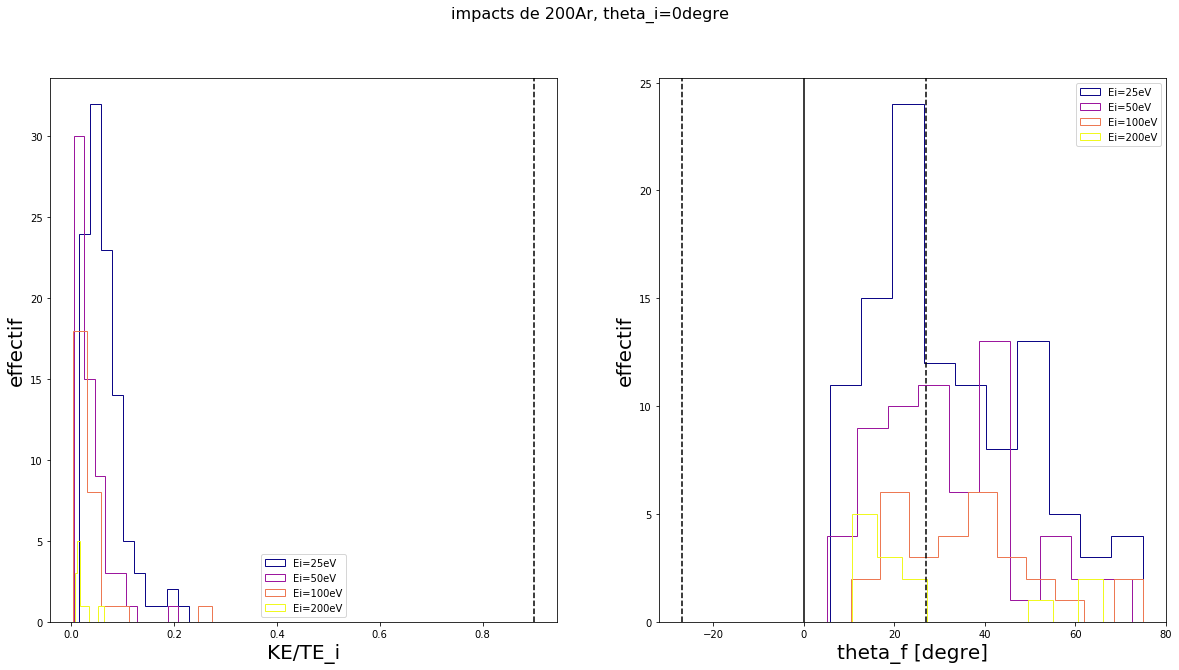

In [8]:
theta_incident=0
critere_out=-2 #d.z>=critere_out
liste_color=plt.cm.plasma(np.linspace(0,1,len(liste_E_incidence)))
liste_nbout=[]

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i in range(len(liste_E_incidence)):
    c=liste_color[i]
    E_incident=liste_E_incidence[i]
    name='Ei_'+str(E_incident)+'_thetai_'+str(theta_incident)
    prem=True
    for i in range(N_simu):
        path = r"/Users/edouardroger/Documents/Cours/X/Projet spatial/Code_MD/md2_sources/"+ion+'_stat/'+name+"/ion/"+complementaire(i)+".ion"
        long=longueur_file(path)

        df_intermediaire=pd.read_csv(path, header=None,usecols=np.arange(0,10).tolist(), skiprows=long-2, names=['Time step','Integration time','KE/TE_i','internal PE','external PE','d.x','d.y','d.z','norm(d)','#b','imp?'],sep="[:,; ]",engine='python')
        dx=df_intermediaire['d.x'].values[-1]-df_intermediaire['d.x'].values[-2]
        dy=df_intermediaire['d.y'].values[-1]-df_intermediaire['d.y'].values[-2]
        dz=df_intermediaire['d.z'].values[-1]-df_intermediaire['d.z'].values[-2]
        dr=np.sqrt(dx**2+dy**2+dz**2)
        theta_sortie=np.arccos(dz/dr)*180/np.pi
        phi_sortie=np.arctan(dy/dx)*180/np.pi
        out=(df_intermediaire['d.z']>=critere_out)

        if i==0:
            df=pd.read_csv(path, header=None,usecols=np.arange(0,10).tolist(), skiprows=long-1, names=['Time step','Integration time','KE/TE_i','internal PE','external PE','d.x','d.y','d.z','norm(d)','#b','imp?'],sep="[:,; ]",engine='python')
            df['theta_f']=theta_sortie
            df['Out?']=out

        else:
            line=pd.read_csv(path, header=None,usecols=np.arange(0,10).tolist(), skiprows=long-1, names=['Time step','Integration time','KE/TE_i','internal PE','external PE','d.x','d.y','d.z','norm(d)','#b','imp?'],sep="[:,; ]",engine='python')
            line['theta_f']=theta_sortie
            line['Out?']=out
            frames = [df, line]
            df = pd.concat(frames)
    
    df=df.reset_index()
    df.drop(['index','Time step', 'Integration time', '#b', 'd.x', 'd.y', 'd.z', 'norm(d)'], axis='columns', inplace=True)
    indexNames = df[ df['Out?'] == False ].index
    df.drop(indexNames , inplace=True)
    liste_nbout.append(len(df))
    
    ax1.hist(df['KE/TE_i'], density=False, histtype='step',color=c,label='Ei='+str(E_incident)+'eV')

    ax2.hist(df['theta_f'], density=False, histtype='step',color=c,label='Ei='+str(E_incident)+'eV')


ax1.set_xlabel('KE/TE_i',size=20)
#ax1.axvline(x=1-0.1*np.cos(theta_incident*np.pi/180), linestyle='--',color='k')
ax1.set_ylabel('effectif',size=20)
ax1.legend()

ax2.set_xlabel('theta_f [degre]',size=20)
ax2.set_ylabel('effectif',size=20)
ax2.axvline(x=theta_incident, linestyle='-',color='k')
#ax2.axvline(x=90-(1.3*(90-theta_incident)), linestyle='--',color='k')
#ax2.axvline(x=90-(0.7*(90-theta_incident)), linestyle='--',color='k')
ax2.legend()

fig.suptitle('impacts de '+str(N_simu)+ion+', theta_i='+str(theta_incident)+'degre', fontsize=16)
fig.show()

liste_nbout=np.array(liste_nbout)/N_simu
print('proportion_out=',liste_nbout)